## Bussiness Understanding
Pada Bussiness Understanding proyek ini bertujuan untuk memahami tentang bisnis ataupun untuk saving, yaitu bagaimana meningkatkan akurasi prediksi harga Emas perbulannya agar dapat memberikan informasi yang lebih akurat dalam pengambilan keputusan bisnis atau saving yang lebih baik.

## deskripsi library yang digunakan


In [1]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


## memanggil dataset

In [2]:
df = pd.read_excel('MonthlyGoldPrice.xlsx')

## Data Understanding
Time Series (Monthly)
Date : waktu per bulan dari tahun 1979 sampai 2022
IDR : harga dalam rupiah


## deskripsi dataset

In [3]:
df.head()

,Date,IDR
0,31011979,139739.28
1,28021979,154683.13
2,30031979,148844.15
3,30041979,152453.63
4,31051979,171656.12


## Data Preparation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    518 non-null    int64  
 1   IDR     518 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.2 KB


## transform data

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format="%d%m%Y")
df.head()

,Date,IDR
0,1979-01-31,139739.28
1,1979-02-28,154683.13
2,1979-03-30,148844.15
3,1979-04-30,152453.63
4,1979-05-31,171656.12


In [6]:
df.set_index(['Date'], inplace=True)

In [7]:
df.index.min(), df.index.max()

(Timestamp('1979-01-31 00:00:00'), Timestamp('2022-02-28 00:00:00'))

In [8]:
if (df.index.max() - df.index.min() == 214) :
    print ('Data is Continous')

In [9]:
df.index.freq = 'BM'

## analisa time series

<Axes: xlabel='Date'>

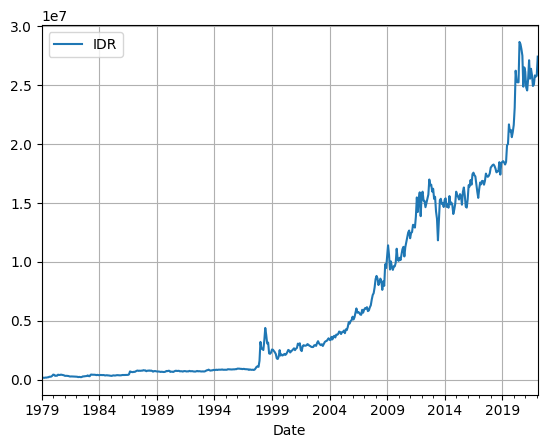

In [10]:
df.plot(grid=True)

In [11]:
train_df = df.loc[:'2020-10-30']
test_df = df.loc['2020-11-30':]

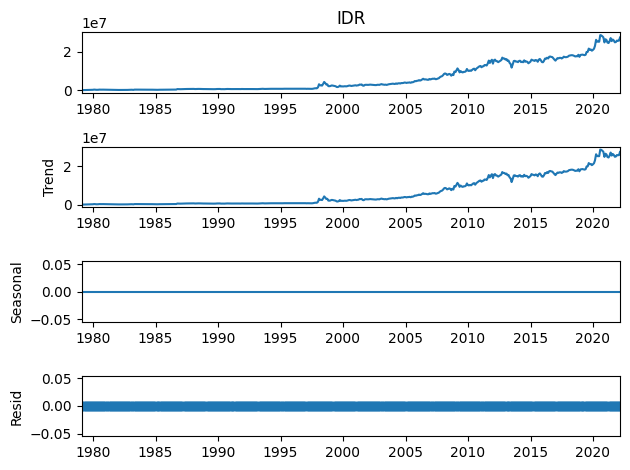

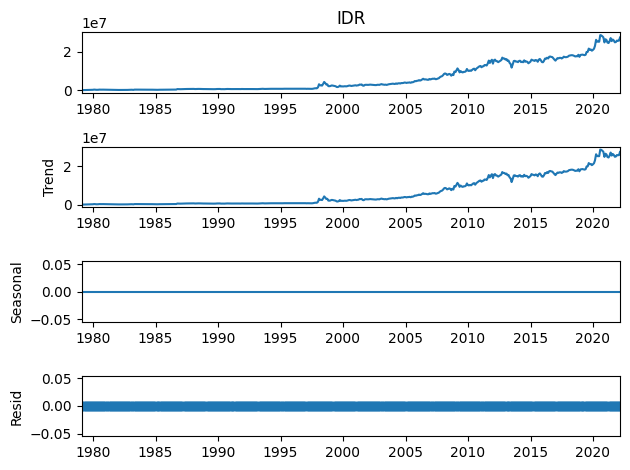

In [12]:
decompose_add = seasonal_decompose(df['IDR'],model='additive',period=1)
decompose_add.plot()

In [13]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('-------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic', 'p-value', 'Lags Used', 'Number of Observatin Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
-------------------------------
Test statistic                 2.910383
p-value                        1.000000
Lags Used                      8.000000
Number of Observatin Used    509.000000
Critical Value (1%)           -3.443263
Critical Value (5%)           -2.867235
Critical Value (10%)          -2.569803
dtype: float64


In [14]:
diff_df = df.diff()
diff_df.head()

,IDR
Date,
1979-01-31,NaN
1979-02-28,14943.85
1979-03-30,-5838.98
1979-04-30,3609.48
1979-05-31,19202.49


In [15]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Date'>

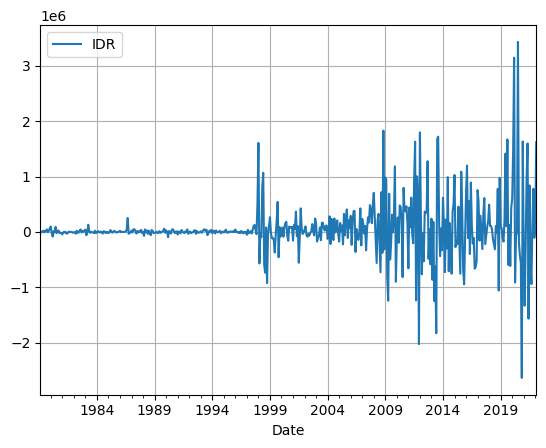

In [16]:
diff_df.plot(grid=True)

In [17]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
-------------------------------
Test statistic              -9.160786e+00
p-value                      2.536464e-15
Lags Used                    7.000000e+00
Number of Observatin Used    5.090000e+02
Critical Value (1%)         -3.443263e+00
Critical Value (5%)         -2.867235e+00
Critical Value (10%)        -2.569803e+00
dtype: float64


c:\Users\fadya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


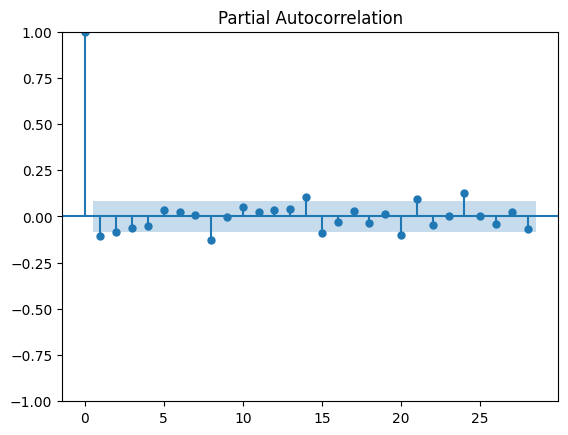

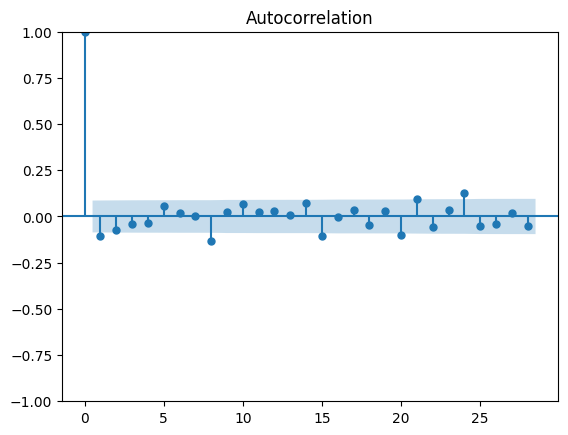

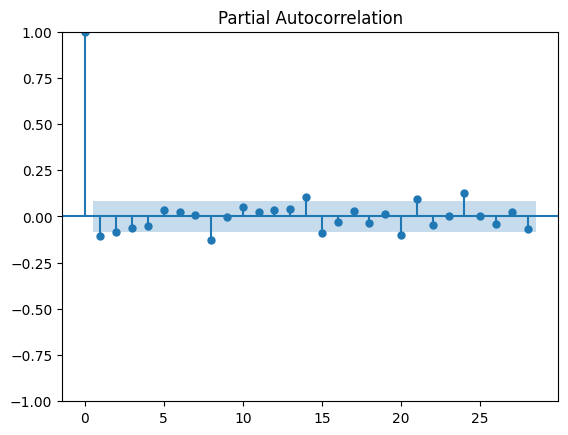

In [18]:
plot_acf(diff_df)
plot_pacf(diff_df)

## Modelling

## Single Exponential Smoothing

In [19]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(16)

c:\Users\fadya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Date'>

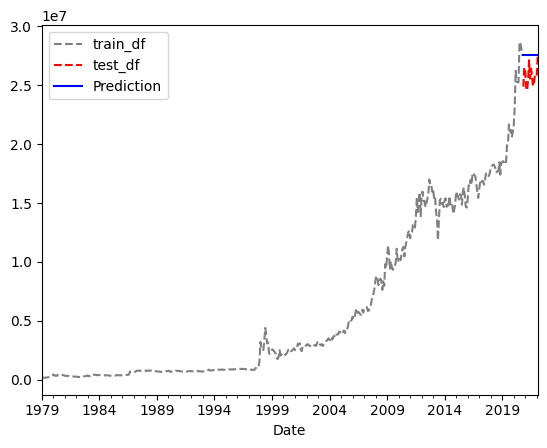

In [20]:
train_df['IDR'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['IDR'].plot(style='--', color='red', legend=True, label='test_df')
single_exp_test_pred.plot(color='blue', legend=True, label='Prediction')

In [21]:
print('Train RMSE :', mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE : 459450.93056538195
Test RMSE : 1965708.635465868
Train MAPE : 0.04558499362548513
Test MAPE : 0.07072519045281189


## Double Exponential Smoothing

In [22]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(16)

c:\Users\fadya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Date'>

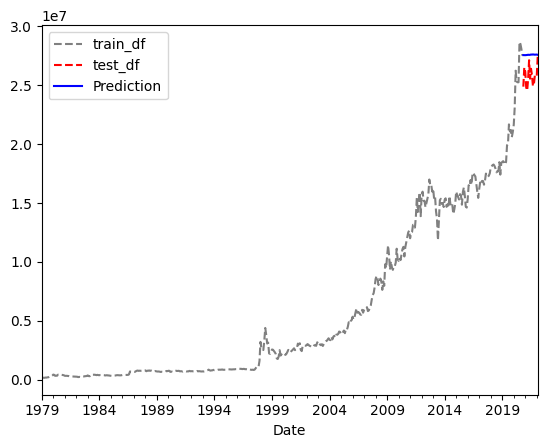

In [23]:
train_df['IDR'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['IDR'].plot(style='--', color='red', legend=True, label='test_df')
double_exp_test_pred.plot(color='blue', legend=True, label='Prediction')

In [24]:
print('Train RMSE :', mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE : 458674.74239448324
Test RMSE : 1991978.713903351
Train MAPE : 0.049520649864794965
Test MAPE : 0.07183095136258785


## ARIMA

In [25]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(16)

c:\Users\fadya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

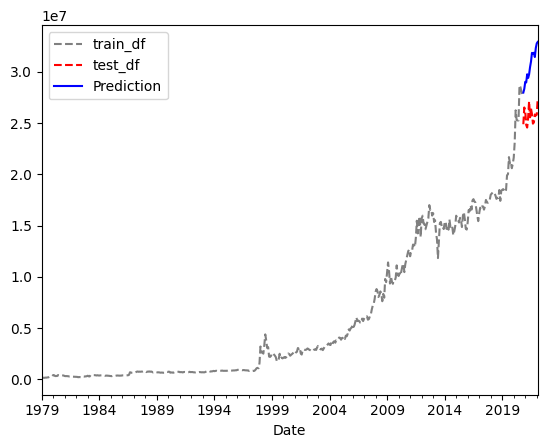

In [26]:
train_df['IDR'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['IDR'].plot(style='--', color='red', legend=True, label='test_df')
ar_test_pred.plot(color='blue', legend=True, label='Prediction')

In [27]:
print('Train RMSE :', mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE :', mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE : 416017.1532096184
Test RMSE : 5086049.712575593
Train MAPE : 0.05407670571643403
Test MAPE : 0.1882559785205103


## Evaluation Model

## perbandingan algoritma

In [28]:
comparision_df = pd.DataFrame(data=[['Single Exp Smoothing',1965708.635465868 ,0.07072519045281189],
['Double Exp Smoothing',1991978.713903351 ,0.07183095136258785 ],['ARIMA',5086049.202051431 , 0.188256012506009 ]],columns=['Model','RMSE','MAPE'])
comparision_df.set_index('Model', inplace=True)


In [29]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Single Exp Smoothing,1.965709e+06,0.070725
Double Exp Smoothing,1.991979e+06,0.071831
ARIMA,5.086049e+06,0.188256


## Deployment

In [30]:
import pickle

In [33]:
pickle.dump(double_exp, open('prediksi_gold.sav','wb'))

## Streamlit